# Post processing approaches

### Import statements

In [551]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
np.set_printoptions(linewidth=1000)
from scipy.sparse.linalg import lgmres
import sympy as sp
import pandas as pd

import scipy.optimize as opt
from scipy.ndimage import sobel
from scipy.optimize import minimize


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

import random
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [552]:
# global stuff

init_GD = []
final_GD = []
dev_GD = []

init_OP = []
final_OP = []
dev_OP = []

### Test with mock points

In [553]:
# experiment with mock points

# Create some example correspondence points
msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 5, 5)) # depth, rows, cols

deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

dx = lgmres(A, Xd, tol = 1e-2)[0]
print("dx shape:", dx.shape)
print("dx:", dx)
print(f'deformation_i.shape: {deformation_i.shape}')

# Show values
np.set_printoptions(linewidth=1000)
print("A shape:", A.shape)
#print(A.toarray())
print("Rank of A:", np.linalg.matrix_rank(A.toarray()))
print("Yd shape:", Yd.shape)
print(Yd)
print("Xd shape:", Xd.shape)
print(Xd)
print("Zd shape:", Zd.shape)
print(Zd)


dx shape: (25,)
dx: [ 1.92045841  2.19371007  2.99974044  0.09595895 -2.99974044  1.65265726  1.65555701  1.48884074  0.27782782 -0.92292217  1.38276003  1.29155864  1.02934627  0.45552205 -0.04563881  1.20243271  1.10130517  0.88692761  0.5778933   0.34180955  1.119485    1.02732735  0.85251929  0.6445325   0.49838286]
deformation_i.shape: (3, 1, 5, 5)
A shape: (25, 25)
Rank of A: 25
Yd shape: (25,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Xd shape: (25,)
[ 0.  0.  3.  0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Zd shape: (25,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_26732/801346265.py:17: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  dx = lgmres(A, Xd, tol = 1e-2)[0]


## Jacobian Computations

In [554]:
'''
Erroeneous Jacobian methods do not use
'''
# def compute_jacobian2D(phix, phiy):
#     ''' 
#     phix, phiy: (5,5)
#     '''
#     """Computes the Jacobian determinant J(x) for a 2D deformation field."""
#     dphix_dx = np.gradient(phix, axis=1)
#     dphiy_dx = np.gradient(phiy, axis=1)
#     dphix_dy = np.gradient(phix, axis=0)
#     dphiy_dy = np.gradient(phiy, axis=0)

#     dphix_dx = dphix_dx.astype(np.float64)
#     dphiy_dx = dphiy_dx.astype(np.float64)
#     dphix_dy = dphix_dy.astype(np.float64)
#     dphiy_dy = dphiy_dy.astype(np.float64)

#     J = (1+dphix_dx)*(1+dphiy_dy) - dphix_dy*dphiy_dx # Jacobian determinant formula
#     return J, dphix_dx, dphix_dy, dphiy_dx, dphiy_dy


# def jacobian_det1(deformation_i):
#     '''
#     expects shape (2,5,5)
#     '''
#     phix = deformation_i[1,:,:]
#     phiy = deformation_i[0,:,:]
#     return compute_jacobian2D(phix, phiy)


'\nErroeneous Jacobian methods do not use\n'

In [555]:
def jacobian_det2D(phi_xy):
    deformation = np.zeros((3,1, *phi_xy.shape[-2:])    )
    deformation[2] = phi_xy[1]
    deformation[1] = phi_xy[0]
    return jacobian.sitk_jacobian_determinant(deformation)

## Gradient descent approach

In [556]:
def gradient_descent_2D(phi_prime, A, Xd, Yd, max_iters=1000, step_size=0.1):
    '''
    expects shape (2,5,5)
    Iteratively enforces J(phi) > 0 by modifying phi using Kuhn-Tucker conditions.
    '''

    
    # cannot replace by ones as gradient descent will just stop
    phi = phi_prime.copy()
    
    for _ in range(max_iters):
        J, dphix_dx, dphix_dy, dphiy_dx, dphiy_dy = jacobian_det1(phi)
        violations = J <= 0  # Identify grid points where constraint is violated
        #print(f'violations are at {J[violations]}')
        
        if not np.any(violations):
            break  # Stop if all Jacobians are positive
        
        # Compute the update using the gradient of J
        #dphix_dx, dphix_dy, dphiy_dx, dphiy_dy = gradients

        #grad_J_phix = dphiy_dy - dphiy_dx 
        #grad_J_phiy = dphix_dx - dphix_dy

        grad_J_phix = (1+dphiy_dy)*np.gradient(dphix_dx, axis=1) - dphiy_dx*np.gradient(dphix_dy, axis=0)
        grad_J_phiy = (1+dphix_dx)*np.gradient(dphiy_dy, axis=0) - dphix_dy*np.gradient(dphiy_dx, axis=1)

        #grad_J_phix = (1+dphiy_dy)*(np.gradient(dphix_dx, axis=1)/dphix_dx) - dphiy_dx*(np.gradient(dphix_dy, axis=0)/dphix_dy)
        #grad_J_phiy = (1+dphix_dx)*(np.gradient(dphiy_dy, axis=0)/dphiy_dy) - dphix_dy*(np.gradient(dphiy_dx, axis=1)/dphiy_dx)
        
        # Apply Kuhn-Tucker update rule only at violating points
        lambda_vals = np.zeros_like(J)
        lambda_vals[violations] = step_size  # Adjust step size adaptively if needed
        
        phi[1, :, :] -= (lambda_vals / 2) * grad_J_phix  # Update phix
        phi[0, :, :] -= (lambda_vals / 2) * grad_J_phiy  # Update phiy

    dxi = phi_prime[1, :, :].flatten()
    dyi = phi_prime[0, :, :].flatten()
    dxf = phi[1, :, :].flatten()
    dyf = phi[0, :, :].flatten()

    init_error = np.sqrt(np.sum((A @ dxi - Xd)**2) + np.sum((A @ dyi - Yd)**2))
    fin_error = np.sqrt(np.sum((A @ dxf - Xd)**2) + np.sum((A @ dyf - Yd)**2))
    deviation = np.sqrt(np.sum((dxi-dxf)**2) + np.sum((dyi-dyf)**2))
    
    init_GD.append(init_error)
    final_GD.append(fin_error)
    dev_GD.append(deviation)

    print(f'GD initial error: {init_error}')
    print(f'GD result error: {fin_error}')
    print(f'GD deviation from original: {deviation}')
    
    return phi

## SciPy optimise approach

### Full SLSQP

In [557]:
def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

# Define the objective function
def objective(phi, A_, b_):
    return np.linalg.norm(A_ @ phi - b_)**2

# Define the constraints
def jdet_constraint(phi, idx, idx_adj, y_offset, epsilon=1e-6):
    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
        
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx)# - epsilon

def scipy_minimize(A, Xd, Yd, fixed_sample, methodName='SLSQP'):
    
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]
    phi = phi_xy

    y_offset = len(b_) // 2
    idx_adj = idx_adjacency(fixed_sample.shape)

    # Create the constraints
    constraints = []
    y_offset = len(b_) // 2
    idx_adj = idx_adjacency(fixed_sample.shape)
    for i in range(len(b_) // 2):
        constraints += [{'type': 'ineq', 'fun': lambda phi, i=i: jdet_constraint(phi, i, idx_adj, y_offset)}]

    # Initial guess
    phi0 = phi_xy

    # Solve the optimization problem
    print(f'Reached the optimisation line. Number of constraints = {len(constraints)}')
    start = time.time()

    result = minimize(lambda phi: objective(phi, A_, b_), phi0, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)

    end = time.time()
    print(f'Optimisation completed! Time taken = {end-start}s')
    
    init_error = objective(phi0, A_, b_)
    fin_error = result.fun
    deviation = np.sqrt(np.sum((phi0 - result.x)**2))
    
    init_OP.append(init_error)
    final_OP.append(fin_error)
    dev_OP.append(deviation)

    # Display the solutions
    if result.success:
        print(f'OP phi0 error: {init_error}')
        print(f'OP result error: {fin_error}')
        print(f'OP deviation from initial: {deviation}')
    else:
        print("Optimization failed:", result.message)
    
    phi = np.zeros((2, *fixed_sample.shape[1:]))
    phi[1] = result.x[:len(result.x) // 2].reshape(fixed_sample.shape[-2:])
    phi[0] = result.x[len(result.x) // 2:].reshape(fixed_sample.shape[-2:])

    return phi


### Reduce constraints

In [558]:
def reduced_scipy_minimize(A, Xd, Yd, fixed_sample, methodName='SLSQP'):
    
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]

    # Create the constraints
    constraints = []
    y_offset = len(b_) // 2
    idx_adj = idx_adjacency(fixed_sample.shape)

    random_sample = random.sample(range(len(b_)//2), 5)

    for i in random_sample:
        constraints += [{'type': 'ineq', 'fun': lambda phi, i=i: jdet_constraint(phi, i, idx_adj, y_offset)}]

    # Initial guess
    phi0 = phi_xy

    # Solve the optimization problem
    print(f'Running reduced scipy with lesser constraints : {len(constraints)}')
    start = time.time()

    result = minimize(lambda phi: objective(phi, A_, b_), phi0, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)

    end = time.time()
    print(f'Optimisation completed! Time taken = {end-start}s')
    
    init_error = objective(phi0, A_, b_)
    fin_error = result.fun
    deviation = np.sqrt(np.sum((phi0 - result.x)**2))
    
    init_OP.append(init_error)
    final_OP.append(fin_error)
    dev_OP.append(deviation)

    # Display the solutions
    if result.success:
        print(f'OP phi0 error: {init_error}')
        print(f'OP result error: {fin_error}')
        print(f'OP deviation from initial: {deviation}')
    else:
        print("Optimization failed:", result.message)
    
    phi = np.zeros((2, *fixed_sample.shape[1:]))
    phi[1] = result.x[:len(result.x) // 2].reshape(fixed_sample.shape[-2:])
    phi[0] = result.x[len(result.x) // 2:].reshape(fixed_sample.shape[-2:])

    return phi

### Iterative SLSQP

In [559]:
def nearest_center(shape, n):
    near_cent = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                z_cent = z
                y_cent = y
                x_cent = x
                if (x-n < 0):
                    x_cent = n
                elif (shape[2]-x < n+1):
                    x_cent = shape[2]-n-1

                if (y-n < 0):
                    y_cent = n
                elif (shape[1]-y < n):
                    y_cent = shape[1]-n-1
                center_indices = [z, y_cent, x_cent]
                near_cent[l_idx] = center_indices
                # print("Nearest center values for index ", l_idx, center_indices)
    return near_cent

def original_coordinates(shape):
    ori_coord = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                ori_coord[z * shape[1] * shape[2] + y * shape[2] + x] = (z,y,x)
    return ori_coord

# Define the objective function
def objective2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init) + np.linalg.norm(A_ @ phi - b_)

def get_phi_sub(phi, cz, cy, cx, shape, d):
    phix = phi[1][cy-d:cy+d+1, cx-d:cx+d+1]
    phiy = phi[0][cy-d:cy+d+1, cx-d:cx+d+1]
    return np.concatenate([phix.flatten(), phiy.flatten()])

def iterative_scipy_minimize(phi_xy, A_, b_, fixed_sample, methodName='SLSQP'):
    threshold = 0.05
    # monitor total and individual times
    indi_times = []
    tot_start = time.time()
    
    # initialise the phi to be returned
    phi = np.zeros((2, *fixed_sample.shape[1:]))
    phi[1] = phi_xy[:len(phi_xy) // 2].reshape(fixed_sample.shape[-2:])
    phi[0] = phi_xy[len(phi_xy) // 2:].reshape(fixed_sample.shape[-2:])


    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2D(phi).flatten()
    neg_jacobian_indices = np.where(J_init <= threshold)[0]
    neg_jacobian_indices = neg_jacobian_indices[np.argsort(J_init[neg_jacobian_indices])]
    
    print(f'init: Negative Jacobians found at {neg_jacobian_indices}')

    # find the nearest center of a 5x5 matrix around each pixel
    near_cent = nearest_center(fixed_sample.shape, 2)
    ori_coord = original_coordinates(fixed_sample.shape)

    sub_shape = (1,5,5)
    sub_idx_adj = idx_adjacency(sub_shape)

    # perform optimisation for each index with negative Jacobian
    for neg_index in neg_jacobian_indices:
        # if the negative values has already been fixed, skip it
        if (jacobian_det2D(phi).flatten()[neg_index] > threshold):
            continue
        
        z,y,x = ori_coord[neg_index]
        cz, cy, cx = near_cent[neg_index]

        print(f'Iterative: Analysing index {neg_index}: Original coord: {x,y,z}, nearest: {cx, cy, cz}')

        
        # solve linear equations 
        lin_start = time.time()
        phi0_sub, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3))) 
        # print("ALL SHAPES", phi0_sub.shape, A_sub.shape, b_sub.shape)
        lin_end = time.time()
        print(f'Lapl eqns for index {neg_index} solved in {lin_end-lin_start}s')

        # get constraints for optimisation
        constraints = []
        y_offset_sub = len(b_sub)//2
        for i_sub in range(len(b_sub)//2):
            constraints += [{'type': 'ineq', 'fun': lambda phi, i=i_sub: jdet_constraint(phi, i, sub_idx_adj, y_offset_sub, threshold)}]

        op_start = time.time()
        # in objective, should i use phi0_sub or the very initial phi_xy to penalise?

        # REMEMBER TO TURN THIS INTO A VARIABLE
        phi_init_sub = get_phi_sub(phi_xy, cz, cy, cx, fixed_sample.shape, 5)
        result = minimize(lambda phi: objective2(phi, phi_init_sub, A_sub, b_sub), phi_init_sub, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)
        op_end = time.time()

        print(f'Optimisation for index {neg_index} completed in {op_end-op_start}s')
        indi_times.append(op_end-op_start)
        if result.success:
            print(f'OP result error for index {neg_index}: {result.fun}')
        else:
            print("Optimisation failed: ", result.message)

        # substitute values from computed deformation into original phi
        # b_ was XYd, so phi_x is the first half
        phi_x_sub = result.x[:len(result.x) // 2].reshape(sub_shape[-2:])
        phi_y_sub = result.x[len(result.x) // 2:].reshape(sub_shape[-2:])

        #print("RESULT SHAPES", phi[1].shape, phi[1][cx-2:cx+3, cy-2:cy+3].shape, cx-2, cx+3, cy-2, cy+3, cy)

        phi[1][cy-2:cy+3, cx-2:cx+3] = phi_x_sub
        phi[0][cy-2:cy+3, cx-2:cx+3] = phi_y_sub

        # print jacobian modifications
        J = jacobian_det2D(phi).flatten()
        neg_j_iter = np.where(J <= threshold)[0]
        neg_j_iter = neg_j_iter[np.argsort(J[neg_j_iter])]
        print(f'Iterative: {len(neg_j_iter)} -ve jacs now at {neg_j_iter}')


    phi_temp = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    init_error = objective2(phi_xy, phi_xy, A_, b_)
    fin_error = objective2(phi_temp, phi_xy, A_, b_)
    deviation = np.sqrt(np.sum((phi_xy - phi_temp)**2))

    tot_end = time.time()
    print(f'Total time taken for iterative SLSQP : {tot_end - tot_start} split as {indi_times}')
    
    
    return phi

## Miscellanous

#### Jacobian comparisons

In [560]:
# compare sitk Jacobian vs my Jacobian
print("deformation_i.shape ", deformation_i.shape)
j1 = jacobian.sitk_jacobian_determinant(deformation_i)
#j2 = jacobian_det1(deformation_i[1:,0])[0]
j3 = jacobian_det2D(deformation_i[1:,0])
print(j1.shape, j3.shape)
print(j1)
#print(j2)
print(j3)

deformation_i.shape  (3, 1, 5, 5)
(1, 5, 5) (1, 5, 5)
[[[ 1.13662583  1.53964101 -0.04887556 -1.99974044 -0.54784969]
  [ 1.00144987  0.91809174  0.31113541 -0.20588146  0.399625  ]
  [ 0.95439931  0.82329312  0.5819817   0.46250746  0.74941957]
  [ 0.94943623  0.84224745  0.73829406  0.72744097  0.88195813]
  [ 0.95392117  0.86651714  0.80860258  0.82293178  0.92692518]]]
[[[ 1.13662583  1.53964101 -0.04887556 -1.99974044 -0.54784969]
  [ 1.00144987  0.91809174  0.31113541 -0.20588146  0.399625  ]
  [ 0.95439931  0.82329312  0.5819817   0.46250746  0.74941957]
  [ 0.94943623  0.84224745  0.73829406  0.72744097  0.88195813]
  [ 0.95392117  0.86651714  0.80860258  0.82293178  0.92692518]]]


In [561]:
# reason for Nan is that phiy is mostly zero!
# jacobian_det1(deformation_i[1:,0])

In [562]:
# only change in edge values for compute_jacobian2D()
print('sitk: ', jacobian.sitk_jacobian_determinant(deformation_i))
#print('jacobian_det1(): ', jacobian_det1(deformation_i[1:,0])[0])
#print('jacobian_det2: ', jacobian_det2(deformation_i[1:, 0], deformation_i[1:, 0].shape[1:])[0])

sitk:  [[[ 1.13662583  1.53964101 -0.04887556 -1.99974044 -0.54784969]
  [ 1.00144987  0.91809174  0.31113541 -0.20588146  0.399625  ]
  [ 0.95439931  0.82329312  0.5819817   0.46250746  0.74941957]
  [ 0.94943623  0.84224745  0.73829406  0.72744097  0.88195813]
  [ 0.95392117  0.86651714  0.80860258  0.82293178  0.92692518]]]


## Testing

### Methods defined

In [563]:
def plot_jacobians(msample, fsample, deformation_i, phi_corrected, jacobian_initial, jacobian_final, figsize=(10,10)):
    # plot initial vs final Jacobian

    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_initial.min(), jacobian_final.min(), -1), vcenter=0, vmax=max(jacobian_initial.max(), jacobian_final.max(), 1))


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # jacobians are of shape (1,5,5). Use index [0] for 2D plots
    im0 = axs[0,0].imshow(jacobian_initial[0], cmap='seismic', norm=norm, interpolation='nearest')
    im1 = axs[0,1].imshow(jacobian_final[0], cmap='seismic', norm=norm, interpolation='nearest')

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0,0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation_i.shape[3]), range(deformation_i.shape[2]), indexing='xy')
    print(f'meshgrid shape for plot: {x.shape}')
    
    axs[0,0].set_title('Initial J det')
    axs[0,0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
    axs[0,0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
    axs[0,0].legend()

    axs[0,1].set_title('final J det')

    axs[1,0].set_title('Initial deformation')
    axs[1,0].quiver(x, y, -deformation_i[2,0], deformation_i[1,0])

    axs[1,1].set_title('final deformation')
    axs[1,1].quiver(x, y, -phi_corrected[1], phi_corrected[0])

    for i in range(2):
        axs[1,i].invert_yaxis()
    
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.95, 0.5, 0.02, 0.4])
    fig.colorbar(im1, cax=cax)

def tester(msample, fsample, deformation_i, phi_corrected):
    jacobian_initial = jacobian_det2D(deformation_i[1:])
    jacobian_final = jacobian_det2D(phi_corrected)

    # print("JACOBIAN SHAPES", jacobian_initial.shape, jacobian_final.shape)

    # Create DataFrame
    data = {
        ("x-def", "min"): [np.min(deformation_i[2,0]), np.min(phi_corrected[1])],
        ("x-def", "max"): [np.max(deformation_i[2,0]), np.max(phi_corrected[1])],
        ("y-def", "min"): [np.min(deformation_i[1,0]), np.min(phi_corrected[0])],
        ("y-def", "max"): [np.max(deformation_i[1,0]), np.max(phi_corrected[0])],
        ("jacobian", "min"): [np.min(jacobian_initial), np.min(jacobian_final)],
        ("jacobian", "max"): [np.max(jacobian_initial), np.max(jacobian_final)]
    }

    row_names = ["initial", "final"]
    df = pd.DataFrame(data, index=row_names)

    # Print table
    print(df)

    plot_jacobians(msample, fsample, deformation_i, phi_corrected, jacobian_initial, jacobian_final)

In [564]:
def test_grad(fixed_sample, msample, fsample):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    phi_corrected = gradient_descent_2D(deformation_i[1:,0], A, Xd, Yd, max_iters=1000, step_size=0.1)
    tester(msample, fsample, deformation_i, phi_corrected)

def test_scipy(fixed_sample, msample, fsample, methodName='SLSQP'):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    phi_corrected = scipy_minimize(A, Xd, Yd, fixed_sample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected)

def red_test_scipy(fixed_sample, msample, fsample, methodName='SLSQP'):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]
    phi_corrected = iterative_scipy_minimize(phi_xy, A_, b_, fixed_sample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected)

def red_test_scipy2(fixed_sample, msample, fsample, methodName='SLSQP'):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]
    phi_corrected = iterative_scipy_minimize(phi_xy, A_, b_, fixed_sample, fsample, msample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected)
    phi_corrected2 = iterative_scipy_minimize(np.concatenate([phi_corrected[1].flatten(), phi_corrected[0].flatten()]), A_, b_, fixed_sample, fsample, msample, methodName)
    tester(msample, fsample, deformation_i, phi_corrected2)

In [565]:
'''
Plot Jacobians at every iteration
'''

def jdet_constraint2(phi_sub, phi, idx_sub, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, ori_shape, epsilon=1e-6):
    dist = submatrix_size//2
    pixels = submatrix_size*submatrix_size
    phi[1][cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[:pixels].reshape((submatrix_size, submatrix_size))
    phi[0][cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[pixels:].reshape((submatrix_size, submatrix_size))

    phi = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    z,y,x = sub_ori_coord[idx_sub]
    z = z
    y = y+cy-dist
    x = x+cx-dist 

    idx = laplacian.get_laplacian_index(z,y,x, ori_shape)


    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
        
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx)# - epsilon


def iterative_with_jacobians(phi_xy, A_, b_, fixed_sample, methodName='SLSQP'):
    jacobians = []
    threshold = 0.0
    # monitor total and individual times
    indi_times = []
    tot_start = time.time()

    idx_adj = idx_adjacency(fixed_sample.shape)
    y_offset = len(b_)//2
    
    # initialise the phi to be returned
    phi = np.zeros((2, *fixed_sample.shape[1:]))
    phi[1] = phi_xy[:len(phi_xy) // 2].reshape(fixed_sample.shape[-2:])
    phi[0] = phi_xy[len(phi_xy) // 2:].reshape(fixed_sample.shape[-2:])


    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2D(phi)
    jacobians.append(J_init)
    J_init = J_init.flatten()
    neg_jacobian_indices = np.where(J_init <= threshold)[0]
    neg_jacobian_indices = neg_jacobian_indices[np.argsort(J_init[neg_jacobian_indices])].tolist()
    
    print(f'init: Negative Jacobians found at {neg_jacobian_indices}')

    # find the nearest center of a 5x5 matrix around each pixel
    submatrix_size = 5
    near_cent = nearest_center(fixed_sample.shape, submatrix_size//2)
    ori_coord = original_coordinates(fixed_sample.shape)


    sub_shape = (1,submatrix_size, submatrix_size)
    sub_idx_adj = idx_adjacency(sub_shape)
    sub_ori_coord = original_coordinates(sub_shape)

    visited = set()
    ind = 0
    # perform optimisation for each index with negative Jacobian

    # change to while loop to keep list dynamic
    while ind < len(neg_jacobian_indices) and ind < 50:
        neg_index  = neg_jacobian_indices[ind]
        ind += 1

        # if neg_index in visited:
        #     continue

        visited.add(neg_index)

        
        # if the negative values has already been fixed, skip it
        if (jacobian_det2D(phi).flatten()[neg_index] > threshold):
            print(f'Iter: jacobian at index {neg_index} is +ve. skip.')
            continue
        
        z,y,x = ori_coord[neg_index]
        cz, cy, cx = near_cent[neg_index]

        print(f'Iterative: Analysing index {neg_index}: Original coord: {x,y,z}, nearest: {cx, cy, cz}')
        
        # solve linear equations 
        lin_start = time.time()
        phi0_sub, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3))) 
        #print("ALL SHAPES", phi0_sub.shape, A_sub.shape, b_sub.shape)
        lin_end = time.time()
        print(f'Lapl eqns for index {neg_index} solved in {lin_end-lin_start}s')

        # get constraints for optimisation
        constraints = []
        y_offset_sub = len(b_sub)//2
        for i_sub in range(len(b_sub)//2):
            constraints += [{'type': 'ineq', 'fun': lambda phi1, i=i_sub: jdet_constraint2(phi1, phi, i, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, fixed_sample.shape)}]

        # print(f'Constraints for index {neg_index}: {range(len(b_sub)//2)}')
        op_start = time.time()
        # in objective, should i use phi0_sub or the very initial phi_xy to penalise?
        phi_init_sub = get_phi_sub(phi, cz, cy, cx, fixed_sample.shape, submatrix_size//2)

        print(f'phi shapes: {phi0_sub.shape}, {phi_init_sub.shape}')

        result = minimize(lambda phi1: objective2(phi1, phi_init_sub, A_sub, b_sub), phi_init_sub, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)
        
        op_end = time.time()

        print(f'Optimisation for index {neg_index} completed in {op_end-op_start}s')

        indi_times.append(op_end-op_start)
        
        if result.success:
            print(f'OP result error for index {neg_index}: {result.fun}')
        else:
            print("Optimisation failed: ", result.message)

        # substitute values from computed deformation into original phi
        # b_ was XYd, so phi_x is the first half
        phi_x_sub = result.x[:len(result.x) // 2].reshape(sub_shape[-2:])
        phi_y_sub = result.x[len(result.x) // 2:].reshape(sub_shape[-2:])

        #print("RESULT SHAPES", phi[1].shape, phi[1][cx-2:cx+3, cy-2:cy+3].shape, cx-2, cx+3, cy-2, cy+3, cy)

        center_distance = submatrix_size//2
        phi[1][cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_x_sub
        phi[0][cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_y_sub

        # add jacobian to list
        J = jacobian_det2D(phi)
        jacobians.append(J)

        # print jacobian modifications
        J = J.flatten()
        neg_j_iter = np.where(J <= threshold)[0]
        neg_j_iter = neg_j_iter[np.argsort(J[neg_j_iter])]
        phi_flat = np.concatenate([phi[1].flatten(), phi[0].flatten()])

        print(f'Iterative: {len(neg_j_iter)} -ve jacs now at {neg_j_iter} : SITK: {J[neg_j_iter]}. CONSTRAINT: {[jdet_constraint(phi_flat, i, idx_adj, y_offset, threshold) for i in neg_j_iter]}')

        for new_neg in neg_j_iter:
            if new_neg not in neg_jacobian_indices[ind:]:
                neg_jacobian_indices.append(new_neg)

    phi_temp = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    init_error = objective2(phi_xy, phi_xy, A_, b_)
    fin_error = objective2(phi_temp, phi_xy, A_, b_)
    deviation = np.sqrt(np.sum((phi_xy - phi_temp)**2))

    tot_end = time.time()
    print(f'Total time taken for iterative SLSQP : {tot_end - tot_start} split as {indi_times}')
    print(f'Initial error: {init_error}, final error: {fin_error}, deviation: {deviation}')
    
    
    return phi, jacobians

def plot_iterative_jacobians(fixed_sample, msample, fsample, methodName='SLSQP'):
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    # Define the matrix A and vector B

    # A_ is [[L,0], [0,L]]
    # b_ is [[x],[y]]
    A0 = np.zeros((A.shape[0], A.shape[1]))

    # Creating the big combined Laplacian matrix
    A_ = np.block([
        [A.todense(), A0],
        [A0, A.todense()]
    ])
    b_ = np.concatenate([Xd, Yd])
    phi_xy = lgmres(A_, b_, tol = 1e-2)[0]
    phi_corrected, jacobians = iterative_with_jacobians(phi_xy, A_, b_, fixed_sample, methodName)

    # assume jacobians is a list of numpy arrays of shape (1, 5, 5)
    # assume msample and fsample are (N, 3) arrays

    num_jacobians = len(jacobians)
    ncols = min(2, num_jacobians)  # wrap at 2 columns
    nrows = (num_jacobians + ncols - 1) // ncols  # ceiling division

    # Compute color normalization
    all_vals = [j[0] for j in jacobians]  # extract 2D arrays from (1,5,5)
    vmin = min(j.min() for j in all_vals)
    vmax = max(j.max() for j in all_vals)
    norm = mcolors.TwoSlopeNorm(vmin=min(vmin, -1), vcenter=0, vmax=max(vmax, 1))

    # Create subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, jac in enumerate(jacobians):
        im = axs[i].imshow(jac[0], cmap='seismic', norm=norm, interpolation='nearest')
        axs[i].set_title(f'Jacobian #{i}' if i > 0 else 'Initial J det')

        if i == 0:
            axs[i].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving', s=10)
            axs[i].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed', s=10)
            axs[i].legend()

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )

    # Hide any extra axes
    for j in range(len(jacobians), len(axs)):
        axs[j].axis('off')

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cax)

    #plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


(15, 3) (15, 3)


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_26732/224296640.py:191: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


init: Negative Jacobians found at [17, 18, 57, 58, 19, 98, 97, 59, 99, 138, 16]
Iterative: Analysing index 17: Original coord: (17, 0, 0), nearest: (17, 2, 0)
Lapl eqns for index 17 solved in 0.14724516868591309s
phi shapes: (50,), (50,)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19.329545011135984
            Iterations: 31
            Function evaluations: 1583
            Gradient evaluations: 31
Optimisation for index 17 completed in 0.37641215324401855s
OP result error for index 17: 19.329545011135984
Iterative: 3 -ve jacs now at [97 17 96] : SITK: [-2.31600789e-08 -1.25595601e-09 -1.20411206e-09]. CONSTRAINT: [-2.31600788547226e-08, -1.2559560058633679e-09, -1.204112060060325e-09]
Iter: jacobian at index 18 is +ve. skip.
Iter: jacobian at index 57 is +ve. skip.
Iter: jacobian at index 58 is +ve. skip.
Iter: jacobian at index 19 is +ve. skip.
Iter: jacobian at index 98 is +ve. skip.
Iterative: Analysing index 97: Original coord: (17, 

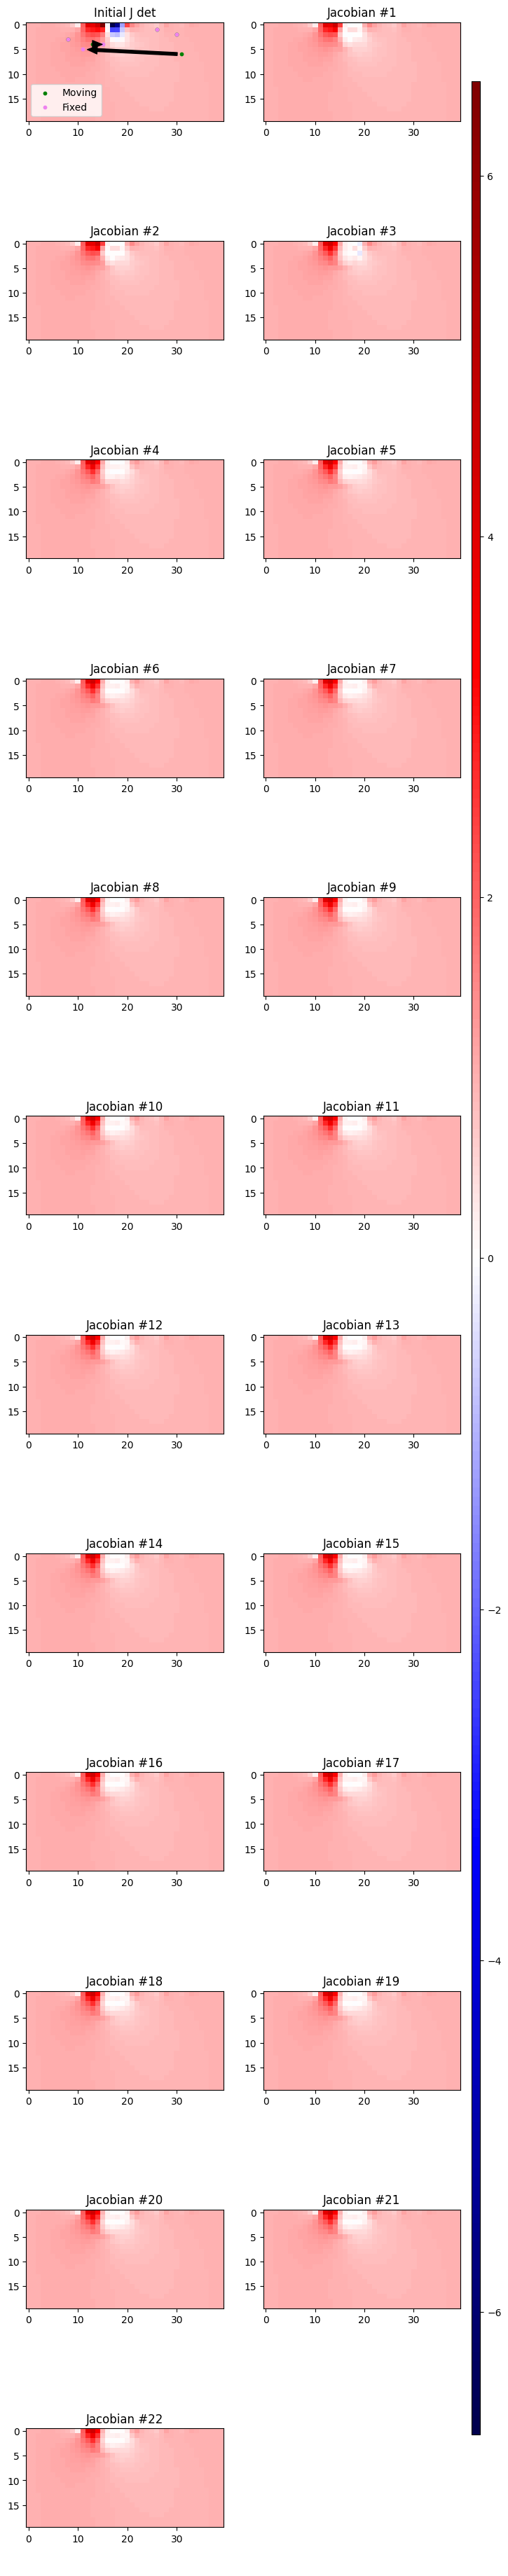

In [566]:
# data analysis

# Create sample set of points
mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
#print(mpoints.shape, fpoints.shape) 

fixed_sample = np.zeros((1, 20, 40))

deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, mpoints, fpoints)

# z values in mpoints, fpoints are for 3 slices numbered 0,1,2
slice_no = 1

# use 
mask = mpoints[:,0]==slice_no
new_mpoints = mpoints[mask].copy()
new_mpoints[:,0] = 0

mask = fpoints[:,0]==slice_no
new_fpoints = fpoints[mask].copy()
new_fpoints[:,0] = 0

print(new_mpoints.shape, new_fpoints.shape)


#test_grad(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, new_mpoints[:5], new_fpoints[:5])
plot_iterative_jacobians(fixed_sample, new_mpoints[:5], new_fpoints[:5])

### Test Jacobian constraint method

In [567]:
# msample = np.array([
#     [0, 1, 0],
#     [0, 2, 3],
# ])
# fsample = np.array([
#     [0, 1, 3],
#     [0, 2, 0],
# ])

# fixed_sample = np.zeros((1, 10, 10)) # depth, rows, cols

# Create sample set of points
mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
#print(mpoints.shape, fpoints.shape) 

fixed_sample = np.zeros((1, 20, 40))

deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
A0 = np.zeros((A.shape[0], A.shape[1]))
# Creating the big combined Laplacian matrix
A_ = np.block([
    [A.todense(), A0],
    [A0, A.todense()]
])
b_ = np.concatenate([Xd, Yd])
phi_xy = lgmres(A_, b_, tol = 1e-2)[0]

# initialise the phi to be returned
phi = np.zeros((2, *fixed_sample.shape[1:]))
y_offset = len(phi_xy)//2
phi[1] = phi_xy[:len(phi_xy) // 2].reshape(fixed_sample.shape[-2:])
phi[0] = phi_xy[len(phi_xy) // 2:].reshape(fixed_sample.shape[-2:])


# collect indices with -ve Jacobians into a list in a sorted fashion
J_sitk = jacobian_det2D(phi)
J_constr = []
idx_adj = idx_adjacency(fixed_sample.shape)

[J_constr.append(jdet_constraint(phi_xy, i, idx_adj, y_offset, 0)) for i in range(len(phi_xy)//2)]
J_constr = np.array(J_constr).reshape(fixed_sample.shape[1:])

print(f'SITK')
print(J_sitk)
print('constraints')
print(J_constr)

sub_J = []
sub_idx = idx_adjacency((1,5,5))
phix_sub = phi[1][:5, :5]
phiy_sub = phi[0][:5, :5]
phi_sub = np.concatenate([phix_sub.flatten(), phiy_sub.flatten()])
sub_ori_coord = original_coordinates((1,5,5))
[sub_J.append(jdet_constraint2(phi_sub, phi, i, 2, 2, 0, 5, idx_adj, y_offset, sub_ori_coord, fixed_sample.shape)) for i in range(25)]
sub_J = np.array(sub_J).reshape((1,5,5))
print(f'sub')
print(sub_J)


SITK
[[[ 1.16582582  1.64549744 -0.00739459 -1.99971898  0.11144987  1.92231152  1.46503966  1.27230766  1.17850305  1.12672947  1.09487037  1.07407601  1.05952561  1.04806789  1.03842816  1.02997909  1.02306516  1.01770827  1.0126095   1.00744706  1.00340973  1.00117522  1.00029821  1.00005659  1.00000735  1.00000072  1.00000004  1.          1.          1.          1.          1.          1.          1.          1.          1.          1.          1.          1.          1.        ]
  [ 1.0177005   0.95919486  0.33199825 -0.20828057  0.4117064   1.11386228  1.19992765  1.17311228  1.13613346  1.10633106  1.08401437  1.06781359  1.05562787  1.04551816  1.03671622  1.0287879   1.02225596  1.0171184   1.01212629  1.00710389  1.00319426  1.00107012  1.00027115  1.0000465   1.0000065   1.00000045  1.00000003  1.          1.          1.          1.          1.          1.          1.          1.          1.          1.          1.          1.          1.        ]
  [ 0.96347939  0.84171755 

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_26732/414329714.py:29: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


### Testing using plots

In [568]:
# UNSTABLE EXAMPLE FOR GRAD DESCENT!!

msample = np.array([
    [0, 0, 1],
    #[0, 2, 0],
    #[0, 3, 0],
    [0, 4, 3],
    #[0, 4, 2],
    [0, 1, 3],
    #[1, 0, 1],
    #[1, 2, 0],
    #[1, 3, 0],
    #[1, 4, 4],
    #[1, 4, 2],
    #[1, 0, 4],
])
fsample = np.array([
    [0, 0, 2],
    #[0, 1, 3],
    #[0, 3, 1],
    [0, 4, 4],
    #[0, 3, 2],
    [0, 1, 0],  # Middle
    #[1, 0, 2],
    #[1, 2, 3],
    #[1, 3, 1],
    #[1, 4, 3],
    #[1, 3, 2],
    #[1, 0, 4],
])

# Create a Laplacian matrix from a sample set of correspondence points
fixed_sample = np.zeros((1, 5, 5))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_26732/224296640.py:191: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


init: Negative Jacobians found at [3, 13, 2]
Iterative: Analysing index 3: Original coord: (3, 0, 0), nearest: (3, 2, 0)
Lapl eqns for index 3 solved in 0.1215670108795166s
phi shapes: (50,), (50,)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.765958756823395
            Iterations: 45
            Function evaluations: 2341
            Gradient evaluations: 45
Optimisation for index 3 completed in 0.4934980869293213s
OP result error for index 3: 4.765958756823395
Iterative: 1 -ve jacs now at [3] : SITK: [-5.15844428e-08]. CONSTRAINT: [-5.158444284518849e-08]
Iter: jacobian at index 13 is +ve. skip.
Iter: jacobian at index 2 is +ve. skip.
Iterative: Analysing index 3: Original coord: (3, 0, 0), nearest: (3, 2, 0)
Lapl eqns for index 3 solved in 0.08273506164550781s
phi shapes: (50,), (50,)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7898831754607079
            Iterations: 16
            Functi

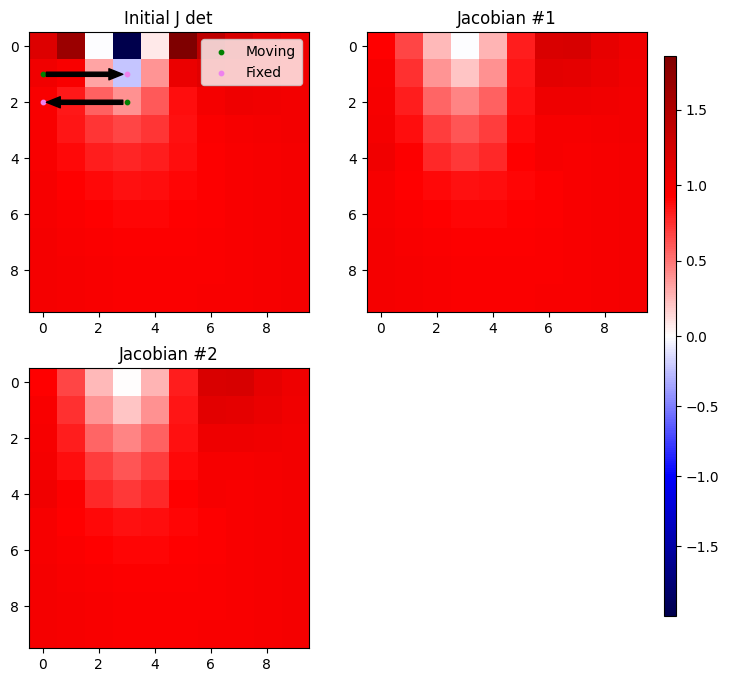

In [569]:
# test gradient descent fjnjk

msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 10, 10)) # depth, rows, cols
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, msample, fsample)
plot_iterative_jacobians(fixed_sample, msample, fsample)

# takes 15 mins and does not conclude on full 20x40 constraints
# 1.5mins on 10x10 constraints
# reduce constraints
# (10,5) - 50 vs 5 - 3.9s vs 0.15s
# (5,5) - 25 vs 5 - 0.35s vs 0.0645s
# (10, 10) - 100 vs 5 - 50s vs 0.46s
# (20, 20) - 400 vs 5 - waited for full one to run for 20min vs 1.5min

# 20x40 with 5 random constraints - 10.5 mins
# 20x40 run over the full thing - 174 min does not finish


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_26732/224296640.py:191: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


init: Negative Jacobians found at [14]
Iterative: Analysing index 14: Original coord: (4, 1, 0), nearest: (4, 2, 0)
Lapl eqns for index 14 solved in 0.11148691177368164s
phi shapes: (50,), (50,)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.852820604307523
            Iterations: 23
            Function evaluations: 1206
            Gradient evaluations: 23
Optimisation for index 14 completed in 0.29534173011779785s
OP result error for index 14: 4.852820604307523
Iterative: 0 -ve jacs now at [] : SITK: []. CONSTRAINT: []
Total time taken for iterative SLSQP : 0.4151780605316162 split as [0.29534173011779785]
Initial error: 0.05993297204732343, final error: 7.552163935904371, deviation: 3.3768105230030128


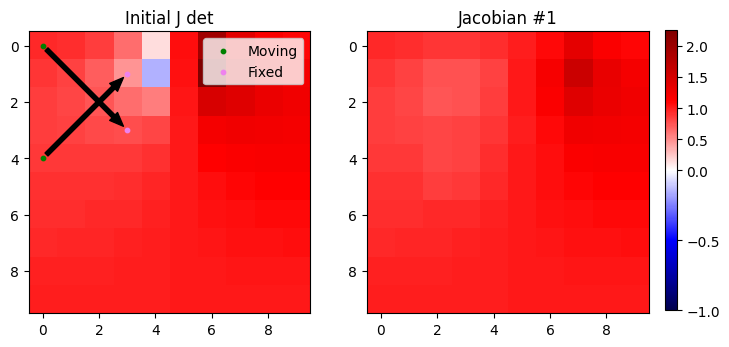

In [570]:
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
plot_iterative_jacobians(fixed_sample, msample, fsample)

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_26732/224296640.py:191: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


init: Negative Jacobians found at [13]
Iterative: Analysing index 13: Original coord: (3, 1, 0), nearest: (3, 2, 0)
Lapl eqns for index 13 solved in 0.1616971492767334s
phi shapes: (50,), (50,)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.8472807099727815
            Iterations: 22
            Function evaluations: 1152
            Gradient evaluations: 22
Optimisation for index 13 completed in 0.26379895210266113s
OP result error for index 13: 4.8472807099727815
Iterative: 0 -ve jacs now at [] : SITK: []. CONSTRAINT: []
Total time taken for iterative SLSQP : 0.4334728717803955 split as [0.26379895210266113]
Initial error: 0.028527755021771566, final error: 7.558718402918813, deviation: 3.379670973941017


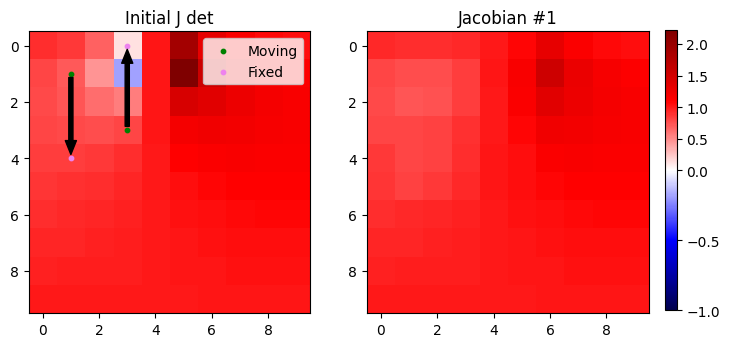

In [571]:
msample = np.array([
    [0, 1, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 4, 1],
    [0, 0, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
plot_iterative_jacobians(fixed_sample, msample, fsample)

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_26732/224296640.py:191: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.
  phi_xy = lgmres(A_, b_, tol = 1e-2)[0]


init: Negative Jacobians found at [5, 6]
Iterative: Analysing index 5: Original coord: (5, 0, 0), nearest: (5, 2, 0)
Lapl eqns for index 5 solved in 0.1401679515838623s
phi shapes: (50,), (50,)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.6551396751811174
            Iterations: 43
            Function evaluations: 2247
            Gradient evaluations: 43
Optimisation for index 5 completed in 0.4801149368286133s
OP result error for index 5: 2.6551396751811174
Iterative: 0 -ve jacs now at [] : SITK: []. CONSTRAINT: []
Iter: jacobian at index 6 is +ve. skip.
Total time taken for iterative SLSQP : 0.6263759136199951 split as [0.4801149368286133]
Initial error: 0.040386216874490066, final error: 4.024302054895663, deviation: 2.0429348106448244


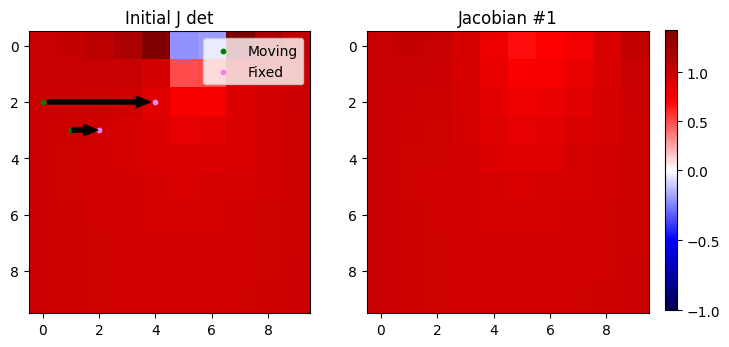

In [572]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, msample, fsample)
plot_iterative_jacobians(fixed_sample, msample, fsample)

In [573]:
# # # plot graphs of errors
# # init_GD = [0.039, 0.048, 0.039, 0.011]
# # final_GD = [12.9, 3.39, 2.162, 4.282]
# # dev_GD = [9.46, 2.27, 1.181, 2.497]

# # init_OP = [0.0015, 0.0033, 0.0015, 0.0001]
# # final_OP = [5.32, 0.235, 0.0289, 0.497]
# # dev_OP = [18.57, 3.315, 1.2811, 1.144]

# indices = range(len(init_GD))

# fig, ax = plt.subplots(1, 2, figsize=(15,5))

# ax[0].set_title('Error of final phi')
# ax[1].set_title('Deviation from phi_prime')
# ax[0].plot(indices, init_GD, label='init phi err', marker='.')
# ax[0].plot(indices, final_GD, label='GD final err', marker='.')
# ax[1].plot(indices, dev_GD, label='GD', marker='.')

# ax[0].plot(indices, init_OP, label='init_phi_err_OP', marker='.')
# ax[0].plot(indices, final_OP, label='cobyla fin err', marker='.')
# ax[1].plot(indices, dev_OP, label='cobyla', marker='.')

# for i in range(2):
#     ax[i].set_xticks(indices)
#     ax[i].legend()


### Test with actual data - corrections needed

In [574]:
# data analysis

# Create sample set of points
mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

In [575]:
# # data analysis

# # Create sample set of points
# mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
# fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"



# mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
# print(mpoints.shape, fpoints.shape)

# for i in [0,1,2]:
#     print(np.max(mpoints[i]), np.min(mpoints[i]), np.max(fpoints[i]), np.min(fpoints[i]))

# #print(fpoints) 

### Treating correspondences as soft constraints

In [576]:
# compute deformation, find negative Jacobian points, find nearest correspondence, remove it and recompute
# what is the guarantee that the nearest correspondence is the problematic one? 
# to find the problematic one we end up arriving at Andy's approach
